In [3]:
import transformers
import os
transformers.__version__

'4.31.0'

In [6]:
from datasets import list_datasets, load_dataset
datasets_list = list_datasets()

### Load dataset form HuggingFace

In [44]:
# download and prepare cc_new dataset
dataset = load_dataset('cc_news', split = 'train')
dataset

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/ashwinram472/.cache/huggingface/datasets/text/cc_news-3f1090ef0b821d15/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


Dataset({
    features: ['text'],
    num_rows: 700000
})

In [51]:
dataset = dataset.select(range(100))

#### Splitting data into train test split

In [31]:
d = dataset.train_test_split(test_size = 0.1)
d['train'], d['test']

(Dataset({
     features: ['text'],
     num_rows: 630000
 }),
 Dataset({
     features: ['text'],
     num_rows: 70000
 }))

### Training Tokenizer

Tokenizer expects text file in which each sample is separated by new line

In [10]:
#Creating text data
from tqdm.auto import tqdm

text_data = []
file_count = 0

for sample in tqdm(dataset):
    # Remove existing new line characters
    sample = sample['text'].replace('\n', ' ')
    text_data.append(sample)
    if len(text_data) == 10000:
        with open(f'./cc_news/file_{file_count}.txt', 'w', encoding = 'utf-8') as f:
            f.write('\n'.join(text_data))
        text_data= []
        file_count += 1
        


  0%|          | 0/700000 [00:00<?, ?it/s]

In [11]:
# Get the paths for all the files
from pathlib import Path
# Within this directory select all text files
paths = [str(x) for x in Path('./cc_news').glob('**/*.txt')]
paths[:2]

['cc_news/file_8.txt', 'cc_news/file_13.txt']

In [54]:
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer(
    clean_text = True, # converts all whitespace into spaces
    handle_chinese_chars = False, # Adds spaces around the chinese characters
    strip_accents = False, # e' -> e # Doenst remove accents
    lowercase = True, #A == a
)

In [55]:
tokenizer.train(files= paths,
               vocab_size = 30000,
               min_frequency=2, ## Minimum number of chars to be considered as a token,
               special_tokens = [
                   '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '<S>', '<T>'],
               limit_alphabet = 1000, # Limit number of single character tokens
               wordpieces_prefix = '##', # surf , ##ing
               )

#### Creating Pairs Dataset

In [52]:
dataset

Dataset({
    features: ['text'],
    num_rows: 100
})

In [53]:
dataset['text'][0].split('.')

["There's a surprising twist to Regina Willoughby's last season with Columbia City Ballet: It's also her 18-year-old daughter Melina's first season with the company",
 ' Regina, 40, will retire from the stage in March, just as her daughter starts her own career as a trainee',
 " But for this one season, they're sharing the stage together",
 " Performing Side-By-Side In The Nutcracker Regina and Melina are not only dancing in the same Nutcracker this month, they're onstage at the same time: Regina is doing Snow Queen, while Melina is in the snow corps, and they're both in the Arabian divertissement",
 ' "It\'s very surreal to be dancing it together," says Regina',
 ' "I don\'t know that I ever thought Melina would take ballet this far',
 '" Left: Regina and Melina with another company member post-snow scene in 2003',
 ' Right: The pair post-snow scene in 2017 (in the same theater) Keep reading at dancemagazine',
 'com',
 '']

In [57]:
pairs_data = []

for sample in tqdm(dataset):
    # Remove existing new line characters
    sample = sample['text'].split('.')
    pairs_data.append(sample)

  0%|          | 0/100 [00:00<?, ?it/s]

#### Creating sentence Pairs

In [65]:
pairs = []
for para in tqdm(pairs_data):
    for i in range(len(para)-1):
        first = para[i].strip()
        second = para[i+1].strip()
        
        pairs.append([first, second])

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
pairs[20]

['Sharing their own video on Facebook, which stars principal Paul Craig and soloist Derek Dunn, Boston Ballet threw in a few Balanchine tricks thanks to some props from Prodigal Son',
 'This is officially our new favorite way to get in on the football fun']

##### Save tokenizer

In [56]:
max_length = 1024
tokenizer.enable_truncation(max_length= max_length)
os.mkdir('./pretrained_bert')
tokenizer.save_model('./pretrained_bert')

['./pretrained_bert/vocab.txt']

In [57]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('./pretrained_bert')

In [49]:
tokenizer('Hi, how are you')

{'input_ids': [2, 12618, 18, 2255, 2007, 1995, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

##### Defining config file

In [76]:
with open(os.path.join('./pretrained_bert', 'config.json'), 'w') as f:
    tokenizer_cfg = {
        'do_lower_case' : True,
        'unk_token' : '[UNK]',
        'sep_token' : '[SEP]',
        'pad_token' : '[PAD]',
        'cls_token' : '[CLS]',
        'mask_token' : '[MASK]',
        'model_max_length' : max_length, # Max length in number of tokens for inpute to the model
        'max_len' : max_length #max sequence length
    }
    json.dump(tokenizer_cfg, f)

##### FAST Tokenizer (RUST implementation)

In [77]:
type(tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [68]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('./pretrained_bert')

In [69]:
tokenizer

BertTokenizerFast(name_or_path='./pretrained_bert', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

## BERT Model

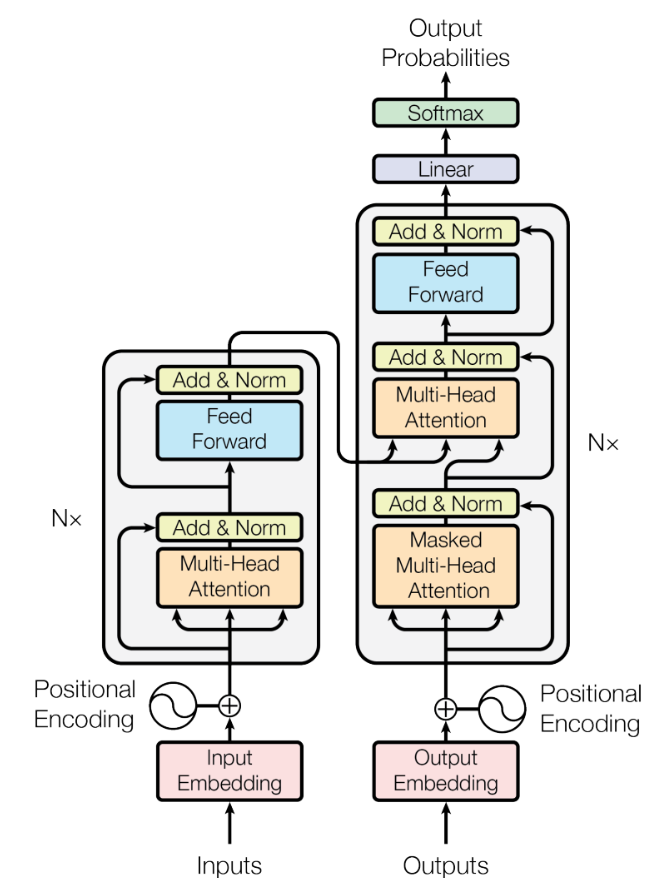

In the Encoder there are Three inputs to the MultiHead Attention
- Value
- Key
- Query

Nx- Represents the repeats for a couple of layers

Positional Encodings: Represent the position of the words

#### PreTraining Dataset - MLM, NSP
- Masked Language Modeling (MLM)
    - Masking 15% of the words using MASK token and predict them.
    - Drawbacks: 
         - Model only tries to predict when the MASK token is present in the input.
         - We want it to predict for evry token in the input
    - Solution:
         - Out of 15% masked tokens:
             - 80% are actually replaced by MASK token
             - 10% are replaced with random token
             - 10% are left unchanged
- Next Sentence Prediction (NSP)
    - Trains models to understand the relationship between two sentences
    - Predicts if if the next sentence is related to the first one.
    - 50% is connected sentences and 50% random sentence sequences
    
- MAX_LEN = 512. Most commong in NLP tasks.

In [82]:
import random
import itertools
from torch.utils.data import Dataset
import torch
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len = 512):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair
    
    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):
        
        ## Get random sentence pair. Either positive or negative NSP
        t1, t2, is_next_label = self.get_sent(item)
        
        ## Replace random words with MASK token
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)
        
        ## Adding CLS and SEP tokens to start and end of sentences
        ## Adding PAD tokens for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]
        
        ## Combine sentence1 and sentence 2 as one input
        ## Adding PAD tokens to make the sentence same length as seq length
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])
        
        #Truncating
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        
        # Padding
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len- len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {'bert_input': bert_input,
                 'bert_label': bert_label,
                 'segment_label': segment_label,
                 'is_next': is_next_label}
    
        return {key: torch.tensor(value) for key, value in output.items()}
        
    def random_word(self, sentence):
        """Masks random words and returns masked sentence"""
        
        #Get individual tokens
        tokens = sentence.split()
        output_label = []
        output = []
        
        # 15% of the tokens to be replaced
        for i, token in enumerate(tokens):
            p = random.random()
            
            # remove CLS and SEP token
            # Tokenizer always adds CLS and SEP to everytime you tokenize
            token_id = self.tokenizer(token)['input_ids'][1:-1]
            
            # if Random 15% replace
            if p < 0.15:
                p /= 0.15
                
                # 80 % chance change token to mask token
                if p < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])
                
                # 10% change change token to random token
                elif p< 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))
                        
                # 10% change change token to current token
                else:
                    output.append(token_id)
                
                #adding the masked token id to label list
                output_label.append(token_id)
                
            # If not 15% append directly
            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)
        

        # Flattening
        output = list(itertools.chain(*[[x] if not isinstance(x,list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x,list) else x for x in output_label]))
        
        assert len(output) == len(output_label)
        return output, output_label
                        
                            
        
    def get_sent(self, index):
        """Return Random sentence Pair"""
        t1, t2 = self.get_corpus_line(index)
        
        # Negative of postive pair for NSP
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0
    
    def get_corpus_line(self, item):
        """Return the sentence pair based on index"""
        return self.lines[item][0], self.lines[item][1]
        
        
    def get_random_line(self):
        """Returns randomly selected sentence"""
        return self.lines[random.randrange(len(self.lines))][1]

In [83]:
MAX_LEN = 512
train_data = BERTDataset(
    pairs, seq_len = MAX_LEN, tokenizer= tokenizer)

In [84]:
train_data[0]

{'bert_input': tensor([    2,     4,     4,     4,    45,  7968, 11876,  1913, 17673, 29974,
            13,    63,  2259,  2474,  1961,     4,  2487, 18211,    32,  1955,
            13,    63,  2158,  2120,  2831,    19,  2054,    19,  2462,  4596,
          4457,  2699,    13,    63,  2212,  2474,  1961,  1900,  2478,     3,
         17673,    18,  3394,    18,  2041,  6161,  2014,  1900,  4394,  1912,
          2953,    18,  2213,     4,  2120,  4596,  5685,     4,  2516,  3725,
          1966,    45,  5229,  2597,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

### Embedding Layer

- Consists of three parts
1. token embeddings
2. segment embeddings
3. position embeddings

    > - Original Transformer BERT had an embedding layer of length 521.
    > - Each dimension captures one feature of the word
    > - During training the words similar to each other get closer
    > - First initialized random values
    
- Position Embeddings
    - Important to keep track of the order of words. Positions influence the meaning of the word
    - LSTMs take the words sequentially so the know its order
    - Transformers dont take it sequentially. So position embeddings are used
    - Cannot add direct word position numbers. Words that appear at the end is a huge number and distort the weight. Like 1, 2, 3
    - Original paper has weight frequencies to calculate the position
        - d - dimension
        - k - position of the output embeddings space
        - n - User defined scalar. Default 10000\
        - i - Mapping to column indices 0 < i <d/2 Single value of i maps to both sine and cosine functions
        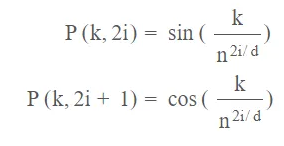
        - Odd positions use sine formula
        - Even position use cosine formula
- All three embeddings should be of size dimensions (Here 768)
- Finally the three embeddings are summed up together to create the embedding layer        

> padding_idx is specified as 0 as to not update it during the training

In [86]:
import math
class PositionalEmbedding(torch.nn.Module):
    
    def __init__(self, d_model, max_len= 128):
        super().__init__()
        #d_model = model dimension
        #max_len = sequence len
        # Compute positional embeddings in log space
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        
        for pos in range(max_len):
            # for each dimension of each position
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/ (10000) ** (2 * i)/ d_model)
                pe[pos, i+1] = math.cos(pos/ (10000) ** (2 * i)/ d_model)
                
        #include batch size
        self.pe = pe.unsqueeze(0)
    
    def forward(self, x):
        return self.pe
    
class BERTEmbedding(torch.nn.Module):
    """
    Consists of three features
    1. Token Embedding: normal embedding matrix
    2. Positional Embedding: positional information using sin, cos
    3. Segment Embedding: adding segment info. Sent A: 1 sent B: 2
    """
    def __init__(self, vocab_size, embed_size, seq_len, drop_out = 0.1):
        """
        vocab_size : total vocab size
        embed_size : embedding size of the token embedding
        dropout: dropout rate
        """
        
        super().__init__()
        self.embed_size = embed_size
        
        #padding is set to 0
        # Size = vocab * 768
        # = 30000 * 768
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx= 0)
        #only creates embeddings sizes based on passing to function()
        # A:1 B:2, Padding: 3
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx = 0)
        self.position = PositionalEmbedding(d_model = embed_size, max_len = seq_len)
        self.dropout = torch.nn.Dropout(p = dropout)
    
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

### Attention Module
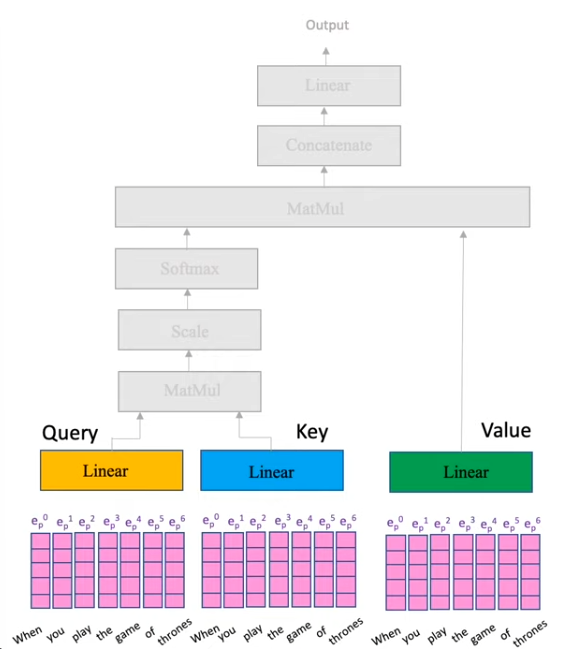
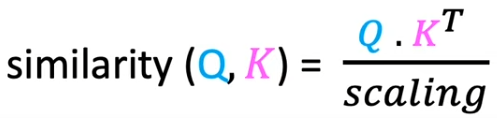
Steps:
- Multiply Query with Key for similarity
- Then scale the multiplied value with the square root of the key dimension
- Then convert everything bw 0 and 1 using a SoftMax function
- Then we get the final Attention Filter
- We then multiply the Attention Filter with Value (original text)

Encoder Layer has 2 sublayers:
 1. MultiHeadedAttention
     Compute the attention weights between each element in input sequence
 2. FeedForward
     One hidden layer that applied GELU activation function to output of first linear layer and produces d_model dimentional output

Each of these sublayers has a residual connection followed by layernormalization Layernorm(x + Sublayer(x)). This helps with solving vanishing gradients in deep networks

In [88]:
class MultiHeadedAttention(torch.nn.Module):
    
    def __init__(self, heads, d_model, dropout = 0.1):
        
        super(MultiHeadedAttention).__init__()
        
        # %Divisible by number of heads
        assert d_model % heads == 0
        
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)
        
        #Shape of the dimension x dimension: K, Q, V
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value has shape: (batch_size, max_len, d_model)
        mask has shape: (batch_size, 1, 1, max_words)
        """
        
        #(batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)
        
        #(batch_size, max_len, d_model) --- > (batch_size, max_len, h, d_k) ---> (batch_size, h, max_len, d_k) 
        #permute is used to amend the layers to match the dot product
        query = query.view(query.shape[0], -1, self.heads(), self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        
        # fill 0 mask with small values for softmax weight calculation (0 causes -inf)
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)  
        
        # Attention Matrix Filter
        weights = F.softmax(scores, dim= -1)
        weights = self.dropout(weights)
        
        #(batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)
    
class FeedForward(torch.nn.Module):
    """Implementation of FNN equation"""
    
    def __init__(self, d_model, middle_dim = 2048, dropout= 0.1):
        super(Feedforward, self).__init__()
        
        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim,d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
    
    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fct2(self.dropout(x))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads = 12,
        feed_forward_hidden = 768 * 4,
        dropout = 0.1
    ):
        super(EncoderLayer, self).__init__()
        #Normalizing layer
        self.layernorm = torch.nn.LayerNorm(d_model)
        #Multihead layer
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        #Feedforward
        self.feed_forward = FeedForward(d_model, middle_dim = feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, embeddings, mask):
        #embeddings (batch_size, max_len, d_model)
        #encoder_mask (batch_size, 1, 1, max_len)
        #result (batch_siez, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        #residual layer
        interacted = self.layernorm(interacted + embeddings)
        #bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded
        

### BERT model

In [91]:
class BERT(torch.nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers
    """
    
    def __init__(self, vocab_size, d_model=768, n_layers = 12, heads = 12, dropout = 0.1):
        """
        vocab_size : vocab size of total words
        d_model: embedding dimensions
        n_layers = number of Transformer blocks (encoder layers)
        heads : number of attentio heads
        dropout : dropout rate
        """
        
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads= heads
        
        # Original BERT used 4 * hidden_size for fft_network_hidden_size
        self.feed_forward_hidden = d_model * 4
        
        #Embedding for BERT, sum of positiona, segment, token_embeddings
        self.embedding = BERTEmbedding(vocab_size = vocab_size, embed_size = d_model)
        
        #multi-layers transformer blocks, deep network
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model *4, dropout) for _ in range(n_layers)])
        
    def forward(self, x, segment_info):
        #Attention mask for padded token
        # (batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        
        #embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)
        
        #running over multiple transformer blocks
        for encoder in self.encoder(blocks):
            x = encoder.forward(x, mask)
        return x

class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model: is_next, is_not_next
    """
    
    def __init__(self, hidden):
        """
        hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim = -1)
    def forward(self, x):
        # use only the first token which is CLS
        return self.softmax(self.linear(x[:,0]))
    
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from Masked input sequence
    n-class classification problem, n_class = vocab_size
    """
    
    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))
    
class BERTLM(torch.nn.Module):
    """
    BERT Language model
    Next Sentence Prediction model + Masked Language model
    """
    
    def __init__(self, bert: BERT, vocab_size):
        """
        bert : BERT model which should be trained
        vocab_size : total vocab_size for masked_lm
        """
        
        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.masked_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)
        
    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)
        

### Optimizer

Original Model used Adam optimizer with custom learning rate scheduler
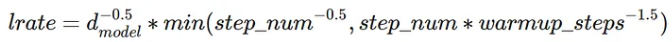


In [92]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## Trainer

In [93]:
class BERTTrainer:
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        ) 

In [ ]:
from torch.utils.data import Dataset, DataLoader
train_data = BERTDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BERTLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
      bert_trainer.train(epoch)